In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict

c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

#### **First, let's go set up LangSmith!**
https://langsmith.com

Next, here is a useful function in LangChain community:

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("who is the vice president of India?")

"Jagdeep Dhankhar: Vice President of India. Jagdeep Dhankhar is an Indian politician and lawyer serving as the vice president of India since 2022. He previously served as the Governor of West Bengal from 2019 to 2022. Jagdeep Dhankhar Born: 1951 (age 74 years), Jhunjhunu, India. Jagdeep Dhankhar Spouse: Sudesh Dhankhar (m. 1979). Jagdeep Dhankhar of the Bharatiya Janata Party is the current vice president. He became vice president after defeating Indian National Congress candidate ... Vice President Of India Shri Jagdeep Dhankhar The Vice-President, Shri Jagdeep Dhankhar addressing the 19th Edition of the CII-ITC Sustainability Awards at ... Jagdeep Dhankhar is an Indian politician and lawyer serving as the vice president of India since 2022. He previously served as the Governor of West Bengal ... Hon'ble Vice-President, Shri Jagdeep Dhankhar and Dr. Sudesh Dhankhar at Baansera Park in New Delhi today. Official Instagram account of the 14th Vice-President of India, Shri Jagdeep Dhankha

#### **Here is a LangChain wrapper class for converting functions into Tools**

In [4]:
from langchain.agents import Tool

tool_search = Tool(
    name="search",
    func=serper.run,
    description="Useful for when you need more information from an Online search."
)

In [5]:
# we can try out the tool in the LangChain way

tool_search.invoke("Tell me about Ahmedabad Boeing plane Crash Incidet in India")

"Air India Flight 171 was a scheduled international passenger flight from Ahmedabad Airport, India to London Gatwick Airport, United Kingdom that crashed about 30 seconds after takeoff at 13:39 IST (08:09 UTC) on 12 June 2025. All but one of the 230 passengers and all 12 crew members died. New details about last month's Air India plane crash in Ahmedabad, which killed 260 people, have emerged this week, shifting focus onto the ... The Air India passenger plane crash in Ahmedabad killed 260 people shortly after taking off on 12 June. It said “Air India crash investigation focuses on movement of engine fuel control switches” with a blurb that “data from the Dreamliner's black ... Crash of Boeing 787 killed 260 people last month · Pilots were experienced; unclear how fuel switches moved · One pilot asked the other why he cut ... Investigation into the tragic crash of Air India Flight AI171 from Ahmedabad ... Boeing. 66K views · 2 days ago #airindiacrash #boeing787 ... Only one passenger s

#### And now, let's write a tool ourselves

In [6]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

In [7]:
def push(text: str):
    """Send a push notification to the user."""
    requests.post(pushover_url, data={'token': pushover_token, 'user': pushover_user, 'message': text})

In [8]:
tool_push = Tool(
    name="send_push_notification",
    func=push,
    description="Useful when you want to send a push notification."
)

In [9]:
# invoking the tool

tool_push.invoke("Hey!, remember me..?")

#### **Back to the graph in Lab 1**
One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. hanges to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

Bring them together!

In [10]:
tools = [tool_search, tool_push]

In [11]:
# Making the State Class

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [12]:
# Starting the graph builder

graph_builder = StateGraph(State)

In [13]:
# this is different 

llm = ChatOpenAI(model = 'gpt-4.1-nano')
llm_with_tools = llm.bind_tools(tools)

In [14]:
# Creating a node
def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Adding the node

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [15]:
# Creating the edges 

graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

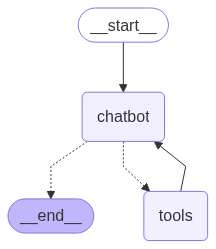

In [16]:
# Compiling the graph

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

#### **And, Let's check if things are in place**

In [17]:
def chat(text: str, history):
    result = graph.invoke({'messages': [{'role': 'user', 'content': text}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


> Do not forget to check the traces at: `https://smith.langchain.com`

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

> stores execution state in memory only (i.e., RAM), not on disk or database.

#### ****It's time to add Memory !****
BUT WAIT !  
We have this whole Graph maintaining the state and appending to the state.
Why isn't this handling memory?

##### This is a crucial point for understanding LangGraph
> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.

One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

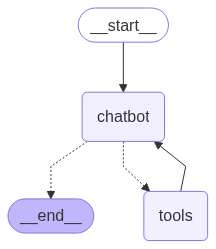

In [19]:
# Step 1 and 2
graph_builder = StateGraph(State)

#Step 3
llm = ChatOpenAI(model='gpt-4.1-nano')
llm_with_tools = llm.bind_tools(tools)

# Step 4
def chatbot(state: State) -> State:
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# now the edges
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))



In [21]:
# This is the main stuff 

config = {"configurable": {'thread_id' : '1'}}

# now the familiar chat function

def chat(user_input: str, history):
    response = graph.invoke({'messages': [{'role': 'user', 'content': user_input}]}, config=config)
    return response["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


> What is `thread_id` ?   
*LangGraph's checkpointer needs a way to uniquely identify the session or thread for which it is saving/restoring state. This is especially important for chatbots or multi-turn conversations.*

In [22]:
# retrieve the current state of a running or previously-run LangGraph workflow, based on a unique configuration or session ID.


graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='\nhey', additional_kwargs={}, response_metadata={}, id='2ede83f2-cd44-44a2-a247-22663a697604'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BvPp0VgDxKzzaiAJfaXGhxc1QBp04', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8e493ae8-f367-4413-ac9f-0c02e826573f-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}, next=(), config={'co

In [23]:
# Most recent first
# retrieve the full history of state transitions that occurred during the execution of a LangGraph workflow session.

list(graph.get_state_history(config))

# every Message(...) has a checkpoint_id

[StateSnapshot(values={'messages': [HumanMessage(content='\nhey', additional_kwargs={}, response_metadata={}, id='2ede83f2-cd44-44a2-a247-22663a697604'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BvPp0VgDxKzzaiAJfaXGhxc1QBp04', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8e493ae8-f367-4413-ac9f-0c02e826573f-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}, next=(), config={'c

#### *LangGraph gives you tools to set thr state back to a prior point in time, to branch off:*

`config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)`

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

In [24]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

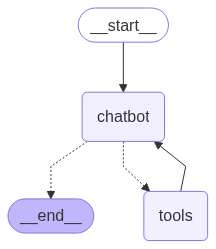

In [25]:
# Steps 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model='gpt-4.1-nano')
llm_with_tools = llm.bind_tools(tools)

# Step 4
def chatbot(state: State) -> State:
    print(state)
    return {'messages': [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 5
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 6
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
# Like we did before 

config = {'configurable': {'thread_id': '3'}}

def chat(user_input: str, history): 
    result = graph.invoke({'messages': [{'role': 'user', 'content' : user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


> After building this interface, I asked it my name, which obviously it didnt know. Then I told it my name.
> After that, I restarted my kernel, cleared all outputs, and then asked it my name --- and guess what, it knew it even after deleting the session

>Still here ?  
> Go check the traces: https://smith.langchain.com/